In [1]:
import shap
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

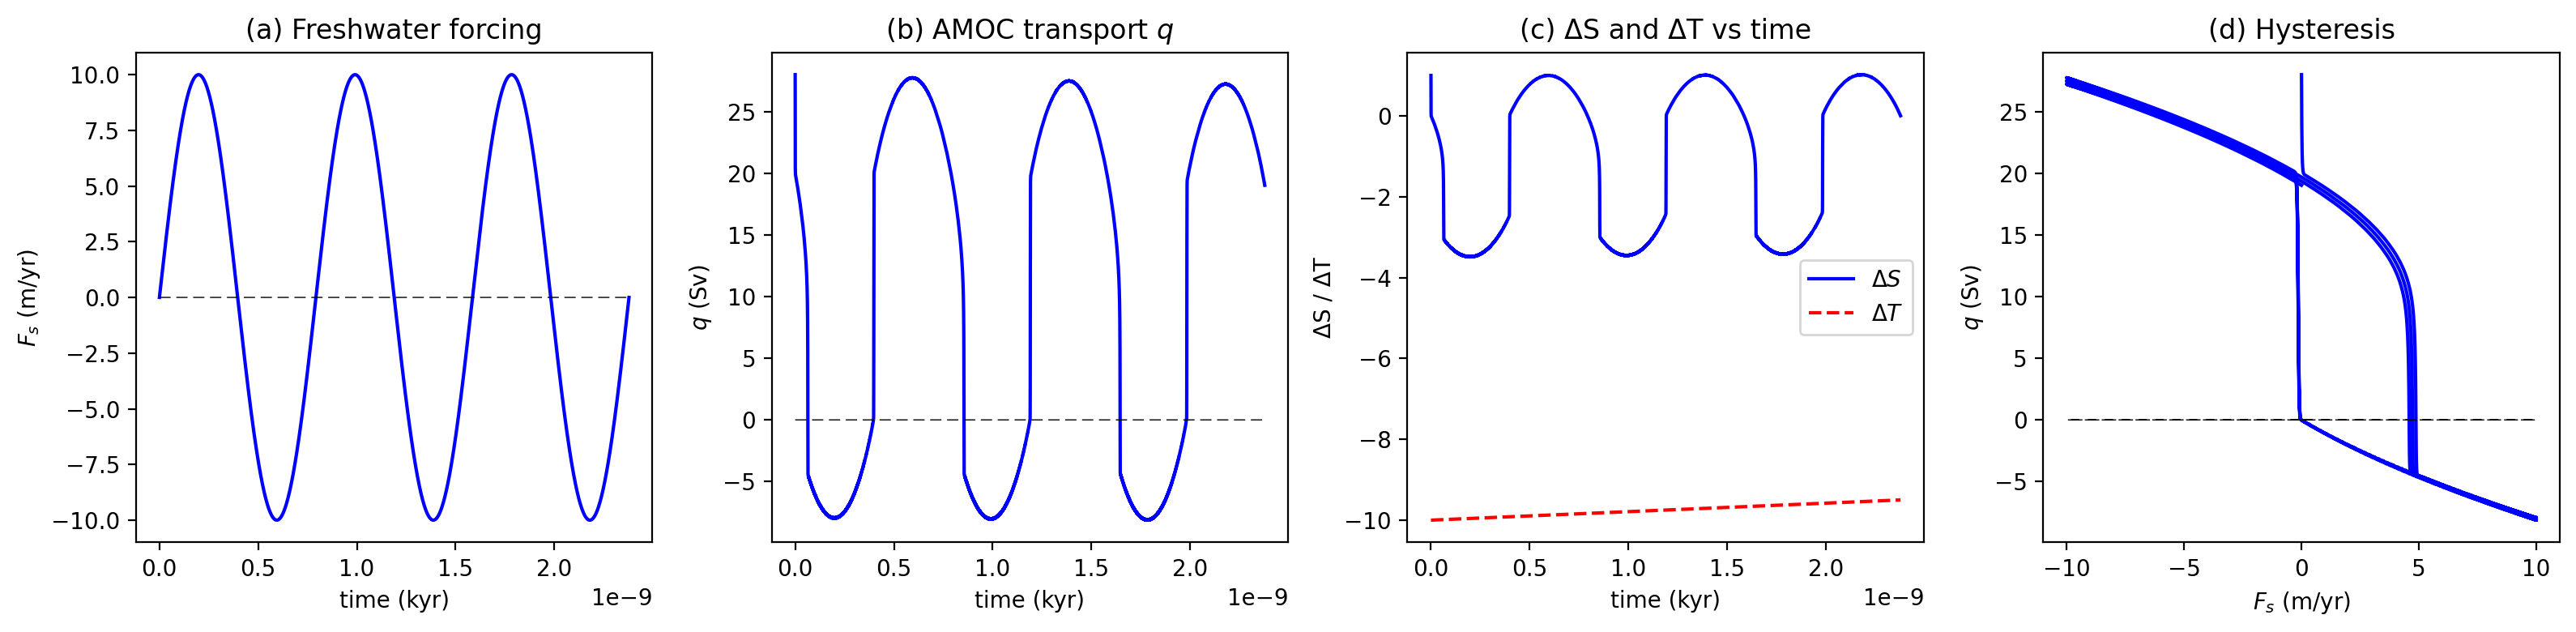

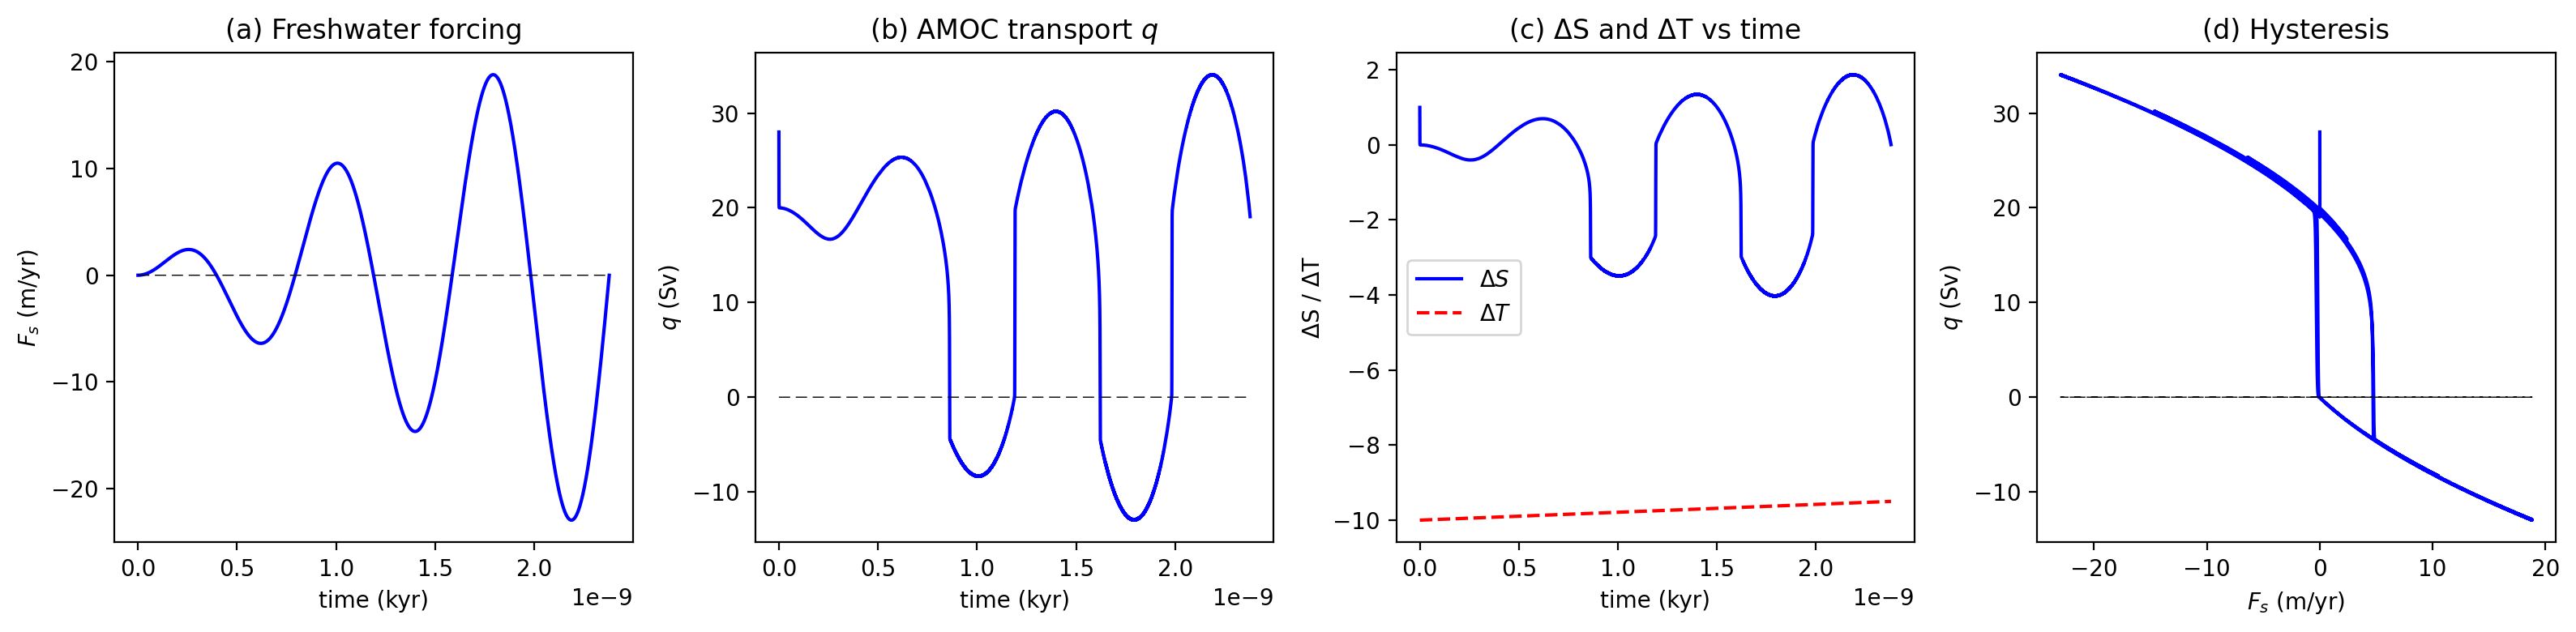

In [2]:
%run 00_generate_data.ipynb

In [3]:
input_data, output_data, qplot = get_data("ns")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [6]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 64
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [7]:
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

# Number of sequences available
num_sequences = input_seq.shape[0]

# Compute gradient for each sequence (using last value or mean)
qplot_smooth = qplot / Sv
seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
])

# Sampling probabilities
seq_probs = seq_grad / seq_grad.sum()

# Sample start indices
sample_size = 250
sample_start_indices = np.random.choice(num_sequences, size=sample_size, replace=False, p=seq_probs)

# Extract sequences
input_samples = input_seq[sample_start_indices]
output_samples = output_seq[sample_start_indices]

In [8]:
# Define a flattened predict function
def predict_flattened(X):
    # Reshape the 2D input back to 3D before passing to the model
    X_reshaped = X.reshape(X.shape[0], time_steps, feature_dim)
    return model.predict(X_reshaped)


In [9]:
background_data = shap.kmeans(X_train_seq.reshape(X_train_seq.shape[0], -1), 25)
feature_names = ['Time', 'Salinity Difference', 'Temperature Difference', 'Freshwater Forcing']

In [10]:
def build_transformer():
    inputs = Input(shape=(None, feature_dim))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

In [11]:
models = []
for i in range(12):
    model = build_transformer()
    model.load_weights(f'models/transformer/nonstationary/ensemble_member_{i}.keras')
    models.append(model)

In [12]:
input_samples_flat = input_samples.reshape(input_samples.shape[0], -1)

In [13]:
shap_values_list = []
for i, model in enumerate(models):
    print(f"Computing SHAP for model {i}")
    explainer = shap.KernelExplainer(predict_flattened, background_data, feature_names=feature_names, num_samples=100)
    shap_values = explainer.shap_values(input_samples_flat)
    shap_values_list.append(shap_values)

Computing SHAP for model 0
1/1 [==============================] - 0s 176ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 6s 3ms/step


2000/2000 [==============================] - 5s 3ms/step
Computing SHAP for model 1
1/1 [==============================] - 0s 112ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 6s 3ms/step


2000/2000 [==============================] - 5s 3ms/step
Computing SHAP for model 2
1/1 [==============================] - 0s 119ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 3ms/step


2000/2000 [==============================] - 6s 3ms/step
Computing SHAP for model 3
1/1 [==============================] - 0s 127ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 3ms/step


2000/2000 [==============================] - 6s 3ms/step
Computing SHAP for model 4
1/1 [==============================] - 0s 91ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 3ms/step


2000/2000 [==============================] - 6s 3ms/step
Computing SHAP for model 5
1/1 [==============================] - 0s 106ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 3ms/step


2000/2000 [==============================] - 6s 3ms/step
Computing SHAP for model 6
1/1 [==============================] - 0s 108ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 3ms/step


2000/2000 [==============================] - 5s 3ms/step
Computing SHAP for model 7
1/1 [==============================] - 0s 107ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 6s 3ms/step


2000/2000 [==============================] - 6s 3ms/step
Computing SHAP for model 8
1/1 [==============================] - 0s 113ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 8s 4ms/step


2000/2000 [==============================] - 5s 2ms/step
Computing SHAP for model 9
1/1 [==============================] - 0s 86ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 2ms/step


2000/2000 [==============================] - 5s 3ms/step
Computing SHAP for model 10
1/1 [==============================] - 0s 100ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 5s 2ms/step


2000/2000 [==============================] - 5s 2ms/step
Computing SHAP for model 11
1/1 [==============================] - 0s 94ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

2000/2000 [==============================] - 7s 3ms/step


2000/2000 [==============================] - 5s 2ms/step


In [14]:
np.save('shap_transformer_ns', np.array(shap_values_list))

In [15]:
len(shap_values_list)

12

In [16]:
#np.save('shap_mlp_ns', shap_values_list_np)

In [17]:
raw_input_sample = input_data[sample_start_indices]
qsample = qplot[sample_start_indices]

In [18]:
shap_values_list_np = np.array(shap_values_list)

In [19]:
shap_values_list_np.shape

(12, 1, 250, 256)

In [20]:
mean_ens = shap_values_list_np.mean(axis=0).squeeze(0)  # (250, 64)

In [21]:
mean_ens.shape

(250, 256)

In [23]:
reshaped = mean_ens.reshape(250, 64, 4)  # (250, time, features)
shap_ensemble_mean = reshaped.mean(axis=1)

In [24]:
shap_ensemble_mean.shape

(250, 4)

In [25]:
shap_temp_mean = shap_ensemble_mean[:, 2]
shap_sal_mean = shap_ensemble_mean[:, 1]

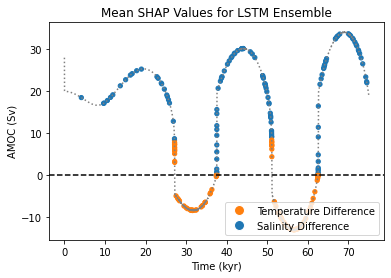

In [26]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp_mean > shap_sal_mean, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 0], qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for LSTM Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

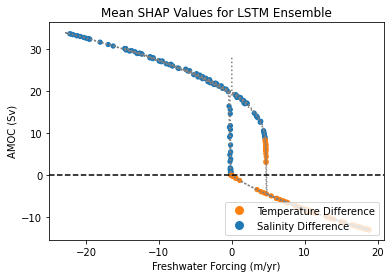

In [27]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp_mean > shap_sal_mean, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 3]/Fs_to_m_per_year, qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for LSTM Ensemble')
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

In [28]:
opposite_idx = np.where(shap_temp_mean * shap_sal_mean < 0)[0]
same_sign_idx = np.where(shap_temp_mean * shap_sal_mean > 0)[0]

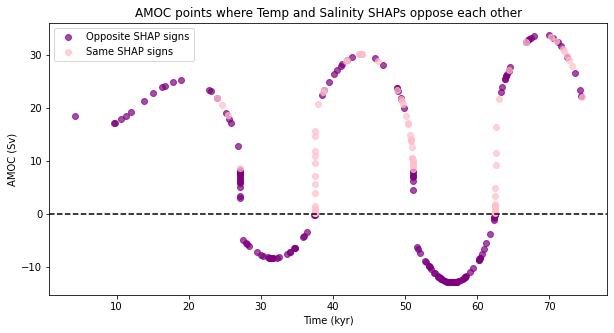

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(raw_input_sample[opposite_idx, 0], qsample[opposite_idx]/Sv,
            color='purple', marker='o', alpha=0.7, label='Opposite SHAP signs')
plt.scatter(raw_input_sample[same_sign_idx, 0], qsample[same_sign_idx]/Sv,
            color='pink', marker='o', alpha=0.7, label='Same SHAP signs')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time (kyr)")
plt.ylabel("AMOC (Sv)")
plt.title("AMOC points where Temp and Salinity SHAPs oppose each other")
plt.legend()
plt.show()


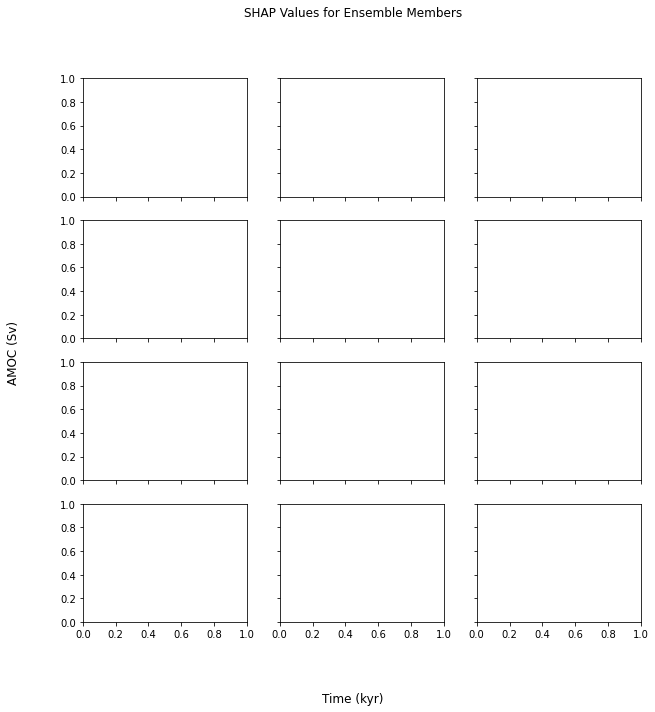

In [30]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('SHAP Values for Ensemble Members')
ax = ax.flatten()

In [31]:
for i in range(12):
    shap_i = np.array(shap_values_list_np)[i, 0, :, :]
    shap_temp = shap_i[:, 2]
    shap_sal = shap_i[:, 1]
    colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

    scatter = ax[i].scatter(raw_input_sample[:, 0], qsample/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
    ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

# After the loop: figure-level legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

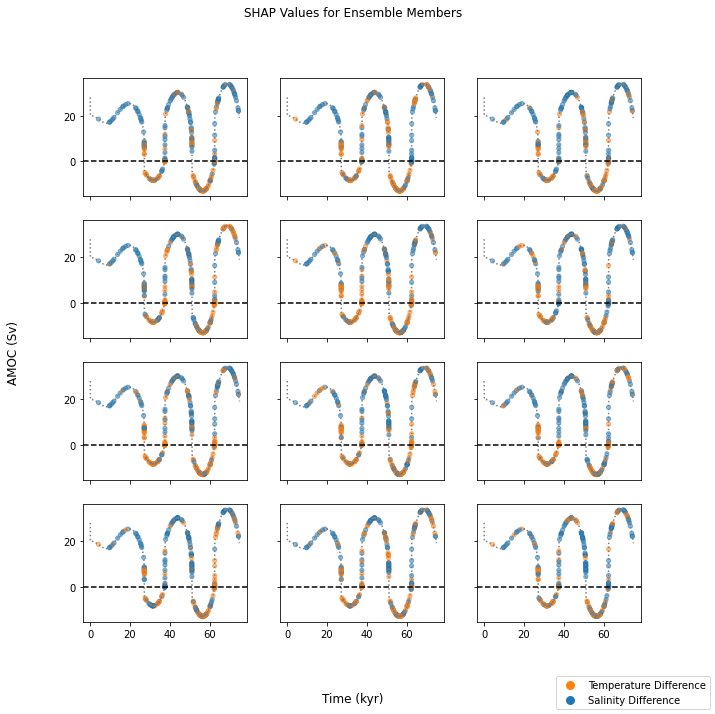

In [32]:
fig

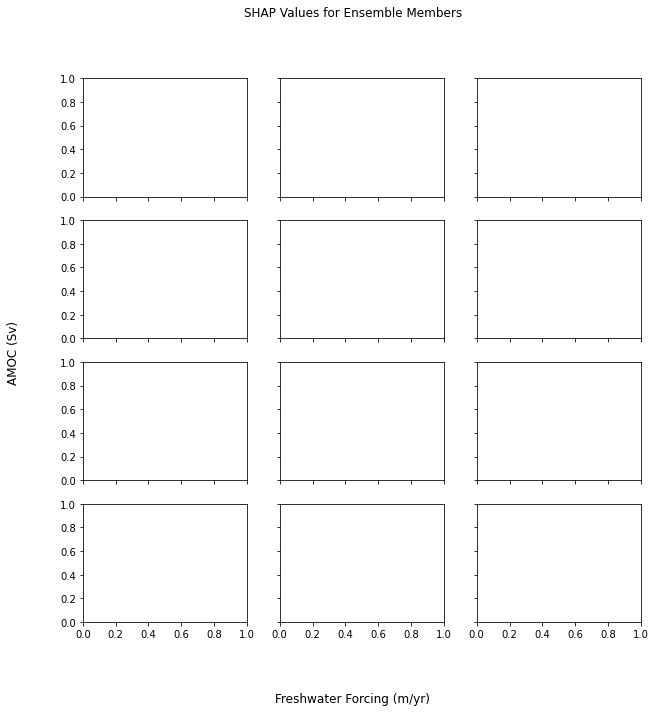

In [33]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('SHAP Values for Ensemble Members')
ax = ax.flatten()

In [34]:
for i in range(12):
    shap_i = np.array(shap_values_list_np)[i, 0, :, :]
    shap_temp = shap_i[:, 2]
    shap_sal = shap_i[:, 1]
    colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

    scatter = ax[i].scatter(raw_input_sample[:, 3]/Fs_to_m_per_year, qsample/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

# After the loop: figure-level legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

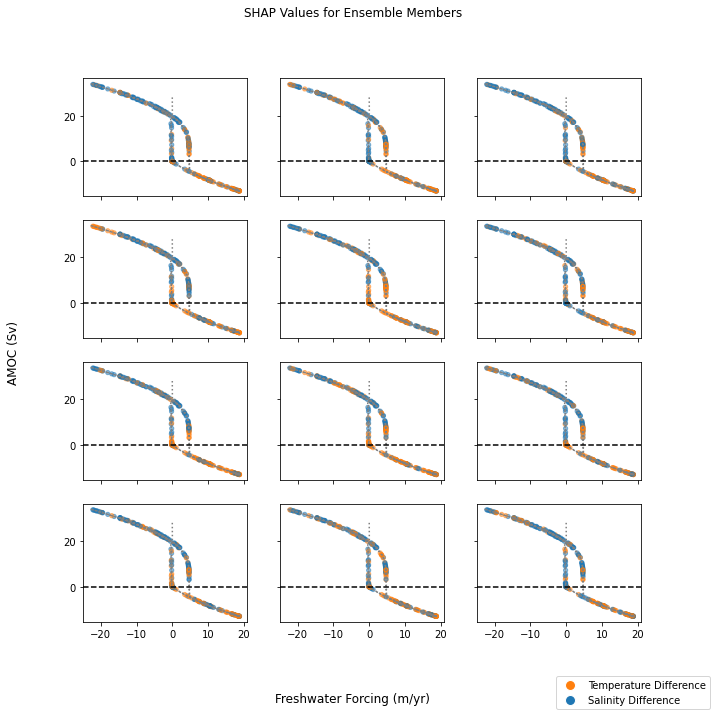

In [35]:
fig